### Test with a 100 _Arabidopsis_ genes and default mapper values

**Imort useful packages / modules**

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML tools
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn import ensemble

# For output display
from IPython.display import IFrame

# If running locally, set current directory as projdir
projdir = '.'

**Mount Google Drive**

Run the next cell __only if you're planning to run this notebook on Google Colab__. If you are running this notebook locally, comment it out.

To run the notebook in Google Colab, it is best if you upload data and script files to a folder in Google Drive and access them from there. We already have a shared Google Drive folder named `PlantsAndPython-2021-10-22` that contains all the required data and script files.
Run the next code cell to mount the drive and make the files accessible. We will define the shared folder as our project directory `projdir`.

If Google drive is not already mounted, running the cell will produce a link. Click on the link, follow the prompts to log in to your google account, and copy the text string generated at the end. Paste the text string in the box below and press `Enter`.

In [2]:
# # Only if running in Google Colab..!!
# # DO NOT run this cell if running locally - simply comment it out.
# from google.colab import drive
# drive.mount('/content/gdrive/')

# projdir = '/content/gdrive/MyDrive/PlantsAndPython-2021-10-22'
# sys.path.append(projdir)

In [3]:
# Make sure your last path is the one were you have this script and your data
sys.path

['/001/usuarios/villasen/Damian/PlantsPython/ClassProject/Mapper',
 '/001/usuarios/villasen/anaconda3/lib/python37.zip',
 '/001/usuarios/villasen/anaconda3/lib/python3.7',
 '/001/usuarios/villasen/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/001/usuarios/villasen/.local/lib/python3.7/site-packages',
 '/001/usuarios/villasen/anaconda3/lib/python3.7/site-packages',
 '/001/usuarios/villasen/anaconda3/lib/python3.7/site-packages/locket-0.2.1-py3.7.egg',
 '/001/usuarios/villasen/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/001/usuarios/villasen/.ipython']

In [4]:
# import helper_functions
from helper_functions import loaddata
from helper_functions import colorscale_from_matplotlib_cmap

# import lense function
from lenses import fsga_transform

# keppler mapper
import kmapper as km

#### Visualizing subsets of metadata and/or data of the *Arabidopsis* class project: 
Which one will be more useful to plot a preliminary mapper graph?



 * **BW**: subsetted by Brandon Webster
 * **RW**: subsetted by Robin Waterman
 * **KD**: subsetted by Kara Dobson
 * **SZ**: subsetted by Sophia Zorrilla
 
 
 *Note: there're probably more subsets hidden among the discord groups*

In [5]:
BW = pd.read_csv('./Databasemetadata.csv', encoding= 'unicode_escape') 
# I used encoding = 'unicode_escape' as a solution
# to an error I otherwise had: 'utf-8' codec can't decode 
# byte 0xea in position 11: invalid continuation byte
BW.head()

,Sample,Project,SampleName,PMID,Genotype,Ecotype,Tissue,TotalReads,UniqueMappedRate,ReleaseDate
0,DRX007662,PRJDB2180,Arabidopsis WT-Col mRNA_seq,/,wild type,Col-0,/,30664389,86.20%,2014/4/2
1,DRX007663,PRJDB2180,Arabidopsis ibm1-4 mRNA_seq,/,ibm1-4,Col-0,/,38551905,91.10%,2014/4/2
2,DRX007664,PRJDB2180,Arabidopsis ibm2-2 mRNA_seq,/,ibm2-2,Col-0,/,37223057,83.40%,2014/4/2
3,DRX014481,PRJDB1593,Y1,/,wild type,/,root,95012910,89.80%,2016/2/5
4,DRX014482,PRJDB1593,Y2,/,wild type,/,root,163269003,92.90%,2016/2/5


In [6]:
RW = pd.read_csv("./result_table.csv", encoding= 'unicode_escape')
RW.head()

,Sample,SampleName,AT1G22630,AT1G22620,AT1G22610,Tissue,Ecotype,Genotype,Treatment,Project,TotalReads,UniqueMappedRatio,ReleaseDate
0,DRX007662,Arabidopsis WT-Col mRNA_seq,37.66,28.68,0.0,--,Col-0,wild type,--,PRJDB2180,30664389,0.8615,4/2/2014
1,DRX007663,Arabidopsis ibm1-4 mRNA_seq,35.22,30.74,0.0,--,Col-0,ibm1-4,--,PRJDB2180,38551905,0.9114,4/2/2014
2,DRX007664,Arabidopsis ibm2-2 mRNA_seq,33.39,28.81,0.0,--,Col-0,ibm2-2,--,PRJDB2180,37223057,0.8343,4/2/2014
3,DRX014481,Y1,8.22,21.83,0.0,root,--,wild type,--,PRJDB1593,95012910,0.8982,2/5/2016
4,DRX014482,Y2,8.53,26.05,0.0,root,--,wild type,--,PRJDB1593,163269003,0.9293,2/5/2016


In [7]:
KD = pd.read_csv("./data_subset.csv")
KD.head() #pre-filtered all samples (rows) have a tissue type

,Unnamed: 0,Sample,SampleName,AT1G22630,AT1G22620,AT1G22610,Tissue,Ecotype,Genotype,Treatment,Project,TotalReads,UniqueMappedRatio,ReleaseDate
0,17117,GSM3178804,urt1 rep1 dataset #2,0.00,0.00,0.0,seedlings,--,urt1,--,PRJNA475117,1039688,0.2002,10/8/2018
1,2820,GSM1507902,Te ctrl rep3,61.64,29.59,0.0,rosette leaf,Te,Te,control,PRJNA261430,24510726,0.8412,9/22/2014
2,16447,GSM2915887,BA_2,19.16,36.65,0.0,seedlings,Col-0,--,BA,PRJNA429126,21775880,0.9044,10/1/2018
3,12342,SRX2899193,Col0_margin_rep2,95.46,23.76,0.0,leaves,Col-0,Col-0,--,PRJNA389787,10077394,0.7901,12/6/2017
4,159,DRX099518,DRS050614,0.00,15.69,0.0,root,Col-0,wild type,Mock,PRJDB6370,3990947,0.9492,9/28/2017


In [8]:
SZ = pd.read_csv("./result_table_100.csv")
SZ.head()

,Sample,SampleName,AT1G06190,AT1G59830,AT4G05510,AT5G45573,AT1G18340,AT4G13770,AT1G05520,AT1G48580,...,AT5G61500,AT5G00910,Tissue,Ecotype,Genotype,Treatment,Project,TotalReads,UniqueMappedRatio,ReleaseDate
0,DRX007662,Arabidopsis WT-Col mRNA_seq,42.03,38.25,0.03,0.0,16.85,15.03,32.44,8.81,...,46.68,0.89,--,Col-0,wild type,--,PRJDB2180,30664389,0.8615,2014/4/2
1,DRX007663,Arabidopsis ibm1-4 mRNA_seq,51.37,35.05,0.00,0.0,18.37,47.83,32.76,6.75,...,46.79,0.00,--,Col-0,ibm1-4,--,PRJDB2180,38551905,0.9114,2014/4/2
2,DRX007664,Arabidopsis ibm2-2 mRNA_seq,45.71,34.51,0.02,0.0,17.35,26.90,34.37,7.66,...,46.82,0.29,--,Col-0,ibm2-2,--,PRJDB2180,37223057,0.8343,2014/4/2
3,DRX014481,Y1,31.10,45.58,0.00,0.0,29.47,51.06,26.40,7.32,...,57.13,0.54,root,--,wild type,--,PRJDB1593,95012910,0.8982,2016/2/5
4,DRX014482,Y2,29.71,40.16,0.00,0.0,26.99,46.15,31.74,9.03,...,49.69,0.38,root,--,wild type,--,PRJDB1593,163269003,0.9293,2016/2/5


In [9]:
Five_tissues = pd.read_csv("./Five_tissues.csv")
Five_tissues

,Unnamed: 0,Sample,SampleName,AT1G06190,AT1G59830,AT4G05510,AT5G45573,AT1G18340,AT4G13770,AT1G05520,...,AT5G61500,AT5G00910,Tissue,Ecotype,Genotype,Treatment,Project,TotalReads,UniqueMappedRatio,ReleaseDate
0,3,DRX014481,Y1,31.10,45.58,0.00,0.0,29.47,51.06,26.40,...,57.13,0.54,root,--,wild type,--,PRJDB1593,95012910,0.8982,05/02/2016
1,4,DRX014482,Y2,29.71,40.16,0.00,0.0,26.99,46.15,31.74,...,49.69,0.38,root,--,wild type,--,PRJDB1593,163269003,0.9293,05/02/2016
2,5,DRX014483,Y9,28.65,37.61,0.00,0.0,26.93,41.27,34.48,...,45.91,0.34,root,--,max1-1,--,PRJDB1593,182427758,0.9305,05/02/2016
3,6,DRX014484,Y10,26.74,42.09,0.00,0.0,25.64,40.41,34.70,...,52.55,0.72,root,--,max1-1,--,PRJDB1593,109750057,0.9298,05/02/2016
4,7,DRX014485,Y11,26.35,37.27,0.00,0.0,25.91,38.70,35.68,...,45.96,0.56,root,--,max1-1,--,PRJDB1593,167993289,0.9242,05/02/2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14813,20012,SRX5371777,Leaf_cold27,62.42,71.22,0.00,0.0,4.14,140.01,42.19,...,41.77,0.49,leaves,Col-0,--,--,PRJNA411947,58332137,0.3767,14/02/2019
14814,20013,SRX5371778,Leaf_cold3,49.69,67.03,0.00,0.0,12.84,130.40,30.87,...,63.92,1.42,leaves,Col-0,--,--,PRJNA411947,19772481,0.7944,14/02/2019
14815,20014,SRX5371779,Leaf_cold3,53.35,71.81,0.00,0.0,12.76,129.63,33.78,...,65.47,1.13,leaves,Col-0,--,--,PRJNA411947,19299384,0.7923,14/02/2019
14816,20066,SRX2095312,VS_480_r3,84.84,42.24,0.00,0.0,6.73,100.53,28.21,...,51.40,0.00,seedlings,vcs-7,vcs (vcs-7 [SOV-L.er]),--,PRJNA341504,24277247,0.8399,26/01/2018


In [10]:
Ecotypes = pd.read_csv("./Five_tissues_ecotype_withoutNaNs.csv")
Ecotypes

,Unnamed: 0,Sample,SampleName,AT1G06190,AT1G59830,AT4G05510,AT5G45573,AT1G18340,AT4G13770,AT1G05520,...,AT5G61500,AT5G00910,Tissue,Ecotype,Genotype,Treatment,Project,TotalReads,UniqueMappedRatio,ReleaseDate
0,24,DRX014760,DRS014294,24.40,31.99,0.00,0.0,5.21,164.02,33.53,...,48.92,0.00,seedlings,Col-0,wild type,--,PRJDB2380,11879962,0.7388,02/01/2017
1,25,DRX014761,DRS014295,27.79,32.08,0.00,0.0,4.74,159.01,29.49,...,51.84,0.00,seedlings,Col-0,wild type,--,PRJDB2380,14640751,0.7499,02/01/2017
2,26,DRX014762,RNA Seq of rfl2_5,31.84,32.91,0.00,0.0,5.00,122.44,31.23,...,44.74,0.00,seedlings,Col-0,rfl2,--,PRJDB2380,14744964,0.7357,02/01/2017
3,27,DRX014763,RNA Seq of rfl2_6,27.06,32.12,0.00,0.0,7.40,136.84,29.27,...,50.32,0.00,seedlings,Col-0,rfl2,--,PRJDB2380,13603449,0.7364,02/01/2017
4,28,DRX016648,WT grown for Dark 0h.,43.30,51.93,0.00,0.0,19.18,0.00,39.39,...,57.82,0.51,whole plant,Col-0,wild type,--,PRJDB2760,137575869,0.6027,27/11/2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13327,20012,SRX5371777,Leaf_cold27,62.42,71.22,0.00,0.0,4.14,140.01,42.19,...,41.77,0.49,leaves,Col-0,--,--,PRJNA411947,58332137,0.3767,14/02/2019
13328,20013,SRX5371778,Leaf_cold3,49.69,67.03,0.00,0.0,12.84,130.40,30.87,...,63.92,1.42,leaves,Col-0,--,--,PRJNA411947,19772481,0.7944,14/02/2019
13329,20014,SRX5371779,Leaf_cold3,53.35,71.81,0.00,0.0,12.76,129.63,33.78,...,65.47,1.13,leaves,Col-0,--,--,PRJNA411947,19299384,0.7923,14/02/2019
13330,20066,SRX2095312,VS_480_r3,84.84,42.24,0.00,0.0,6.73,100.53,28.21,...,51.40,0.00,seedlings,vcs-7,vcs (vcs-7 [SOV-L.er]),--,PRJNA341504,24277247,0.8399,26/01/2018


In [11]:
Genotypes = pd.read_csv("./Five_tissues_genotype_withoutNaNs.csv")
Genotypes

,Unnamed: 0,Sample,SampleName,AT1G06190,AT1G59830,AT4G05510,AT5G45573,AT1G18340,AT4G13770,AT1G05520,...,AT5G61500,AT5G00910,Tissue,Ecotype,Genotype,Treatment,Project,TotalReads,UniqueMappedRatio,ReleaseDate
0,3,DRX014481,Y1,31.10,45.58,0.00,0.0,29.47,51.06,26.40,...,57.13,0.54,root,--,wild type,--,PRJDB1593,95012910,0.8982,05/02/2016
1,4,DRX014482,Y2,29.71,40.16,0.00,0.0,26.99,46.15,31.74,...,49.69,0.38,root,--,wild type,--,PRJDB1593,163269003,0.9293,05/02/2016
2,5,DRX014483,Y9,28.65,37.61,0.00,0.0,26.93,41.27,34.48,...,45.91,0.34,root,--,max1-1,--,PRJDB1593,182427758,0.9305,05/02/2016
3,6,DRX014484,Y10,26.74,42.09,0.00,0.0,25.64,40.41,34.70,...,52.55,0.72,root,--,max1-1,--,PRJDB1593,109750057,0.9298,05/02/2016
4,7,DRX014485,Y11,26.35,37.27,0.00,0.0,25.91,38.70,35.68,...,45.96,0.56,root,--,max1-1,--,PRJDB1593,167993289,0.9242,05/02/2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8932,19991,SRX5309280,WT-ABA-2,74.68,44.59,0.00,0.0,16.92,16.22,41.51,...,54.57,0.32,seedlings,--,wild type,ABA,PRJNA517354,21710822,0.9173,29/01/2019
8933,19992,SRX5309281,kapp-ABA-2,75.01,44.94,0.00,0.0,19.13,14.24,42.78,...,51.04,0.00,seedlings,--,kapp,--,PRJNA517354,25906536,0.9152,29/01/2019
8934,19993,SRX5309282,kapp-ABA-1,75.90,42.04,0.00,0.0,19.77,12.49,39.69,...,53.17,0.00,seedlings,--,kapp,--,PRJNA517354,22345588,0.9157,29/01/2019
8935,20066,SRX2095312,VS_480_r3,84.84,42.24,0.00,0.0,6.73,100.53,28.21,...,51.40,0.00,seedlings,vcs-7,vcs (vcs-7 [SOV-L.er]),--,PRJNA341504,24277247,0.8399,26/01/2018


In [12]:
below_repr_veg_other = pd.read_csv("./below_repr_veg_other.csv")
below_repr_veg_other

,Unnamed: 0,Sample,SampleName,AT1G06190,AT1G59830,AT4G05510,AT5G45573,AT1G18340,AT4G13770,AT1G05520,...,AT5G61500,AT5G00910,Tissue,Ecotype,Genotype,Treatment,Project,TotalReads,UniqueMappedRatio,ReleaseDate
0,0,DRX007662,Arabidopsis WT-Col mRNA_seq,42.03,38.25,0.03,0.0,16.85,15.03,32.44,...,46.68,0.89,other,Col-0,wild type,--,PRJDB2180,30664389,0.8615,2014/4/2
1,1,DRX007663,Arabidopsis ibm1-4 mRNA_seq,51.37,35.05,0.00,0.0,18.37,47.83,32.76,...,46.79,0.00,other,Col-0,ibm1-4,--,PRJDB2180,38551905,0.9114,2014/4/2
2,2,DRX007664,Arabidopsis ibm2-2 mRNA_seq,45.71,34.51,0.02,0.0,17.35,26.90,34.37,...,46.82,0.29,other,Col-0,ibm2-2,--,PRJDB2180,37223057,0.8343,2014/4/2
3,3,DRX014481,Y1,31.10,45.58,0.00,0.0,29.47,51.06,26.40,...,57.13,0.54,belowground,--,wild type,--,PRJDB1593,95012910,0.8982,2016/2/5
4,4,DRX014482,Y2,29.71,40.16,0.00,0.0,26.99,46.15,31.74,...,49.69,0.38,belowground,--,wild type,--,PRJDB1593,163269003,0.9293,2016/2/5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20063,20063,SRX5507299,T18,35.07,37.39,0.00,0.0,15.01,71.68,39.66,...,58.25,0.00,other,Col-0,--,--,PRJNA526597,20711720,0.7676,2019/3/12
20064,20064,SRX5507300,T15,37.30,36.45,0.00,0.0,14.09,80.15,45.09,...,55.13,0.00,other,Col-0,--,--,PRJNA526597,28199351,0.7428,2019/3/12
20065,20065,SRX5507301,T16,36.61,36.08,0.00,0.0,13.74,67.26,37.71,...,57.13,0.00,other,Col-0,--,--,PRJNA526597,22945353,0.7584,2019/3/12
20066,20066,SRX2095312,VS_480_r3,84.84,42.24,0.00,0.0,6.73,100.53,28.21,...,51.40,0.00,other,vcs-7,vcs (vcs-7 [SOV-L.er]),--,PRJNA341504,24277247,0.8399,2018/1/26


In [13]:
below_repr_veg = pd.read_csv("./below_repr_veg.csv", encoding= 'unicode_escape')
below_repr_veg

,Unnamed: 0,Sample,SampleName,AT1G06190,AT1G59830,AT4G05510,AT5G45573,AT1G18340,AT4G13770,AT1G05520,...,AT5G61500,AT5G00910,Tissue,Ecotype,Genotype,Treatment,Project,TotalReads,UniqueMappedRatio,ReleaseDate
0,3,DRX014481,Y1,31.10,45.58,0.00,0.0,29.47,51.06,26.40,...,57.13,0.54,belowground,--,wild type,--,PRJDB1593,95012910,0.8982,05/02/2016
1,4,DRX014482,Y2,29.71,40.16,0.00,0.0,26.99,46.15,31.74,...,49.69,0.38,belowground,--,wild type,--,PRJDB1593,163269003,0.9293,05/02/2016
2,5,DRX014483,Y9,28.65,37.61,0.00,0.0,26.93,41.27,34.48,...,45.91,0.34,belowground,--,max1-1,--,PRJDB1593,182427758,0.9305,05/02/2016
3,6,DRX014484,Y10,26.74,42.09,0.00,0.0,25.64,40.41,34.70,...,52.55,0.72,belowground,--,max1-1,--,PRJDB1593,109750057,0.9298,05/02/2016
4,7,DRX014485,Y11,26.35,37.27,0.00,0.0,25.91,38.70,35.68,...,45.96,0.56,belowground,--,max1-1,--,PRJDB1593,167993289,0.9242,05/02/2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12341,20026,SRX5371791,Young_flower_cold27,56.99,48.88,0.00,0.0,27.84,1.50,46.30,...,52.93,0.50,aboveground reproductive,Col-0,--,--,PRJNA411947,27482722,0.7248,14/02/2019
12342,20027,SRX5371792,Cotyledons_control,77.19,49.73,0.00,0.0,25.47,32.10,24.87,...,44.66,0.00,aboveground vegetative,Col-0,--,Mock,PRJNA411947,17652866,0.8579,14/02/2019
12343,20028,SRX5371793,Cotyledons_control,79.98,47.54,0.00,0.0,21.37,31.55,25.64,...,45.63,0.54,aboveground vegetative,Col-0,--,Mock,PRJNA411947,19780006,0.8552,14/02/2019
12344,20029,SRX5371794,Cotyledons_cold3,75.21,55.87,0.00,0.0,24.31,28.36,32.19,...,39.60,0.27,aboveground vegetative,Col-0,--,3 hours of cold treatment,PRJNA411947,21943998,0.8510,14/02/2019


**Data**

We need to define as our dataframe `df` the database that contains gene columns (cells with gene expression values) and factor columns (ex. stress, tissue type, etc.). 

For this we'll eventually have to merge metadata (the factor columns) with the data (gene expression columns).

### Test with a 100 genes and default mapper values

In [14]:
df = below_repr_veg_other # set dataframe
df_name = 'below-repr-veg-other'
print("The current dataframe name is:", df_name)
print("rows, columns =", df.shape)
print("number of elements =", df.size)

The current dataframe name is: below-repr-veg-other
rows, columns = (20068, 111)
number of elements = 2227548


In [15]:
genes = list(df.columns[3:103]) # create list with the gene names
print(genes)

['AT1G06190', 'AT1G59830', 'AT4G05510', 'AT5G45573', 'AT1G18340', 'AT4G13770', 'AT1G05520', 'AT1G48580', 'AT1G11730', 'AT5G23510', 'AT5G27885', 'AT5G27345', 'AT1G15860', 'AT1G07993', 'AT2G07705', 'AT3G13390', 'AT5G02970', 'AT1G08827', 'AT2G33230', 'AT1G30580', 'AT3G29615', 'AT3G05370', 'AT3G03930', 'AT2G21235', 'AT4G03685', 'AT5G53980', 'AT5G54680', 'AT3G23715', 'AT3G08745', 'AT2G13240', 'AT5G40950', 'AT5G10140', 'AT5G23450', 'AT1G77405', 'AT1G65990', 'AT2G07766', 'AT5G65880', 'AT2G21340', 'AT3G33528', 'AT5G43150', 'AT4G08010', 'AT1G25270', 'AT1G06070', 'AT1G29690', 'AT4G37910', 'AT5G22330', 'AT3G60740', 'AT2G35150', 'AT5G08360', 'AT3G03465', 'AT2G06565', 'AT2G26560', 'AT1G50040', 'AT1G07903', 'AT4G12120', 'AT2G06630', 'AT1G08770', 'AT2G34020', 'AT4G23280', 'AT3G55254', 'AT1G07810', 'AT2G33720', 'AT5G05805', 'AT2G38790', 'AT5G04940', 'AT3G02645', 'AT5G49340', 'AT1G48285', 'AT1G16540', 'AT2G06215', 'AT1G28465', 'AT5G13310', 'AT5G48290', 'AT1G68310', 'AT1G78810', 'AT2G43760', 'AT1G08753'

**Check tissue levels**

There're over 100 different tissue types! But we're mainly interested in aboveground vegetative, aboveground reproductive and belowground.

Tissue types need to be sorted out into these categories (or maybe it has already been done by Kara Dobson or Asia Hightower, but where is the new database? in the HPCC? github? google drive?).

There are 4 tissue types


<AxesSubplot:>

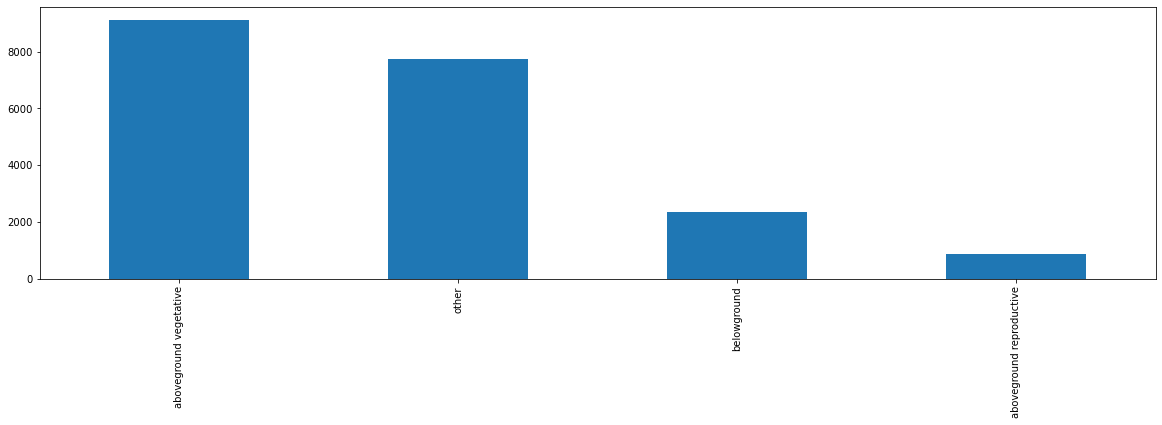

In [16]:
Tissues = df["Tissue"].unique()
print("There are", len(Tissues), "tissue types")
fig = plt.figure(figsize=(20,5))
df['Tissue'].value_counts().plot.bar()

**Check Genotype levels**

There are 1507 genotypes


<AxesSubplot:>

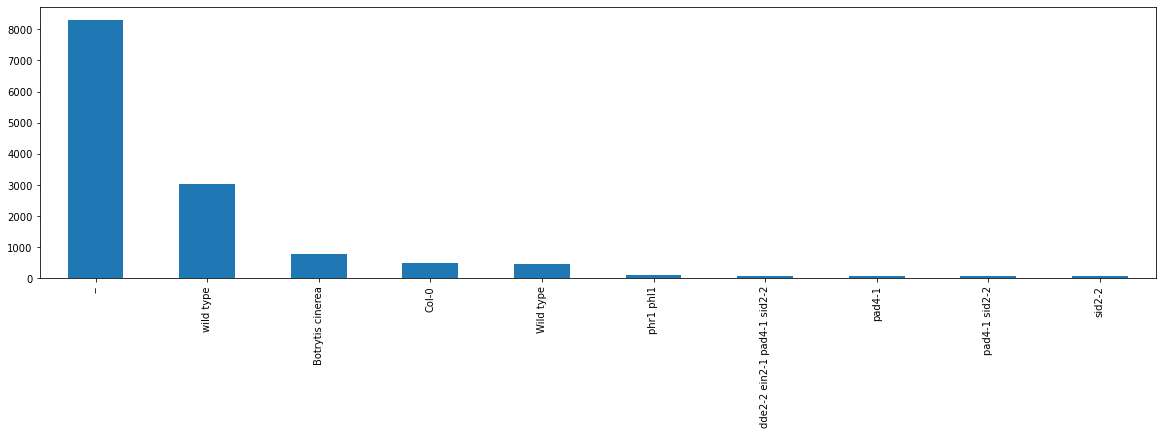

In [17]:
Genotype = df["Genotype"].unique()
print("There are", len(Genotype), "genotypes")
fig = plt.figure(figsize=(20,5))
df['Genotype'].value_counts().head(10).plot.bar() #Plot the first 10 genotypes

**Check Ecotype levels**

There are 1493 ecotypes


<AxesSubplot:>

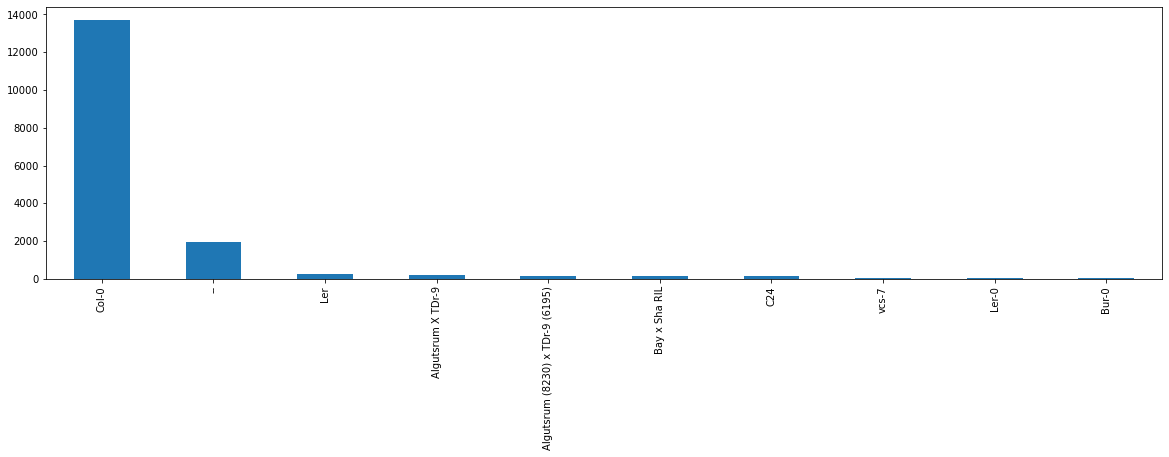

In [18]:
Ecotype = df["Ecotype"].unique()
print("There are", len(Ecotype), "ecotypes")
fig = plt.figure(figsize=(20,5))
df['Ecotype'].value_counts().head(10).plot.bar() #Plot the first 10 genotypes

In [19]:
# Set factors and factors levels

factors = ['Tissue','Genotype','Ecotype']
levels = ['leaves','wild type','Col-0']

filter_by_factor, filter_by_level = ('Tissue', 'belowground')
# filter_by_factor, filter_by_level = ('Ecotype', 'Col-0')
# filter_by_factor, filter_by_level = ('Genotype', 'wild type')

color_by_factor, color_by_level = ('Tissue', 'belowground')
# color_by_factor, color_by_level = ('Genotype', 'wild type')
# color_by_factor, color_by_level = ('Ecotype', 'Col-0')

**Initialize a KeplerMapper object**

You can ignore the `nerve` part.

In [20]:
# Initialize mapper object
mymapper = km.KeplerMapper(verbose=1)

# Define Nerve
nerve = km.GraphNerve(min_intersection=1)

KeplerMapper(verbose=1)


**Define lens / filter function:**

For factor: tissue, and level: root, we take the gene expression profiles of all the root samples from the data and fit a linear model. Then we project all the samples on to this linear model and compute the residuals. The lens is the norm of the residual vector.

In [21]:
# Define lens
scaler = MinMaxScaler()
residuals, idx_tr, idx_te = fsga_transform(df, genes, filter_by_factor, filter_by_level)
lens = mymapper.project(residuals,
                        projection='l2norm', 
                        scaler=scaler)
lens_type = 'NicloauEtAl-2011'

..Projecting on data shaped (20068, 100)

..Projecting data using: l2norm

..Scaling with: MinMaxScaler()



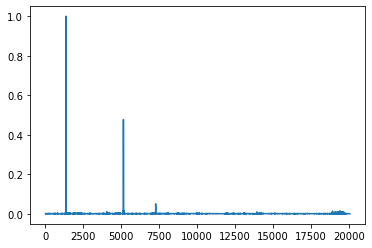

In [22]:
plt.plot(lens)

In [23]:
# Isolation forest lens
X = np.array(df[genes].fillna(0))
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
IFlens = model.decision_function(X).reshape((X.shape[0], 1))
lens_type = 'IsolationForest'

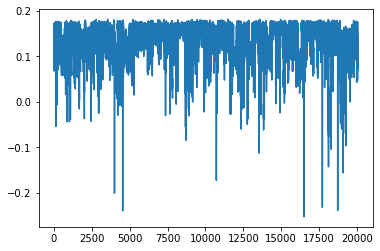

In [24]:
plt.plot(IFlens)

**Other lenses:**
from __[KeplerMapper 2.0.1 documentation](https://kepler-mapper.scikit-tda.org/en/latest/notebooks/Cancer-demo.html)__.

In [25]:
# # We need to determine our 'X' object. In the documentation they used X = np.array(df[feature_names].fillna(0)), 
# # but I was not able to understand what 'feature_names' exactly was

# # Create a custom 1-D lens with Isolation Forest
# model = ensemble.IsolationForest(random_state=1729)
# model.fit(X)
# lens1 = model.decision_function(X).reshape((X.shape[0], 1))
# # For lens1: Lenses that make biological sense; in other words, lenses that highlight special features in the data,
# # that I know about. In the case of this particualr data, using an anomaly score (in this case calculated using 
# # the IsolationForest from sklearn) makes biological sense since cancer cells are anomalous.

# # Create another 1-D lens with L2-norm
# mapper = km.KeplerMapper(verbose=0)
# lens2 = mapper.fit_transform(X, projection="l2norm")
# # For lens2: Lenses that disperse the data, as opposed to clustering many points together.

# # Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, L^2-Norm] lens
# lens = np.c_[lens1, lens2]

# # Create a 1-D lens with the First Principal Component from PCA
# lens3 = mapper.fit_transform(X, projection=PCA(n_components=1))

# # Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, First Principal Component from PCA]
# isoForest_pca = np.c_[lens1, lens3]

# # Create a 1-D lens with the values of the texture_mean feature of the dataset
# lens4 = mapper.fit_transform(X, projection=[1])

# # Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, First Principal Component from PCA]
# texture_l2norm = np.c_[lens4, lens2]

**Define cover:**

Overlap must be between 0 and 100. Intervals must be less than 130.

In [26]:
# Define cover
cubes, overlap = (100, 85) # cubes = intervals
cover = km.cover.Cover(n_cubes=cubes, perc_overlap=overlap/100.)

**Define clustering algorithm:**

DBSCAN with default parameters. Metric: correlation distance (1 - correlation) between a pair of gene expression profiles.

In [27]:
# Define clustering algorithm
clust_metric = 'correlation'
clusterer = DBSCAN(metric=clust_metric)

**Construct the mapper graph:**

Keep an eye on the number of hypercubes, nodes and edges reported by the algorithm. You can change the graph size by changing the cover parameters.

In [28]:
# Create mapper 'graph' with nodes, edges and meta-information.
graph = mymapper.map(lens=IFlens,
                     X=residuals,
                     clusterer=clusterer,
                     cover=cover,
                     nerve=nerve,
                     precomputed=False,
                     remove_duplicate_nodes=True)

Mapping on data shaped (20068, 100) using lens shaped (20068, 1)

Creating 100 hypercubes.
Merged 3 duplicate nodes.

Number of nodes before merger: 71; after merger: 68


Created 361 edges and 68 nodes in 0:00:32.703764.


**Adding components to visualization**

Before we visualize the constructed mapper graph, we will add a couple of components to the visualization.<br>
First, we will color the nodes of the mapper graph using the specified factor (`color_by_factor`). The specified level (`color_by_level`) will be at one end of the colormap, all other levels will be at the other end. The node color is determined averaging the colors of all samples in the corresponding cluster.

In [29]:
# Color nodes by specified color_by_factor, color_by_level

df[color_by_factor] = df[color_by_factor].astype('category')
color_vec = np.asarray([0 if(val == color_by_level) else 1 for val in df[color_by_factor]])
cscale = colorscale_from_matplotlib_cmap(plt.get_cmap('coolwarm'))

In [30]:
# show filter_by_factor levels in tooltip

temp = ['({}, {})'.format(str(p[0]), str(p[1])) for p in zip(df[filter_by_factor], df[color_by_factor])]
df['tooltips'] = temp

**Visualize the mapper graph**

Latly, we create the visualization, save it as an html file, and then load it into a frame.<br>
Alternatively, you can browse to the html file and open it in a separate browser window.

In [31]:
# Specify file to save html output
fname = 'LensType_{}_FilterBy_{}_ColorBy_{}_Data_{}_Cubes_{}_Overlap_{}.html'.format(lens_type,
                                                              filter_by_factor,
                                                              color_by_factor,
                                                              df_name,
                                                              cubes,
                                                              overlap)

figtitle = 'Lens type: {}, Lens factor : {} ({}), Color by {} ({}), Database: {}, intervals {}, overlap {}'.format(lens_type,
                                                                                                              filter_by_factor,
                                                                                                              filter_by_level,
                                                                                                              color_by_factor,
                                                                                                              color_by_level,
                                                                                                              df_name,
                                                                                                              cubes, 
                                                                                                              overlap/100.0)

fpath = projdir + '/' + fname

# Create visualization and save to specified file
_ = mymapper.visualize(graph,
                       path_html=fpath,
                       title=figtitle,
                       color_values=color_vec,
                       color_function_name=color_by_factor,
                       colorscale=cscale,
                       custom_tooltips=df['tooltips'])

# Load the html output file
IFrame(src=fpath, width=1000, height=800)

Wrote visualization to: ./LensType_IsolationForest_FilterBy_Tissue_ColorBy_Tissue_Data_below-repr-veg-other__Cubes_100_Overlap_85.html
